# Task 2: Create a Predictive Algorithm

In your second task, you were expected to create model that classifies your labels that done in the first task.
Create a model by using Python or R. You are free to choose your algorithm and libraries / packages to use.

Finally, tune your hyper-parameters of your model by randomized search, grid search or any other search method and explain your reasoning for this choice.

---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

pd.options.mode.chained_assignment = None

from utils.aux_functions import univariate_analysis, agg_assign

import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [2]:
# read data
df = pd.read_csv('./data/Courier_data.csv')

In [3]:
df.head()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_16,feature_17,weeks_between,lifetime_2,lifetime_1_a,lifetime_1_b,lifetime_1_c,lifetime_1_d,lifetime_1,flag
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,...,1,19,999,33.0,0,1,0,0,2.0,1
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,...,3,11,1,33.0,0,1,0,0,2.0,1
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,...,1,10,0,33.0,0,1,0,0,2.0,1
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,...,1,30,0,33.0,0,1,0,0,2.0,1
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,...,1,4,999,35.0,1,0,0,0,1.0,0


In [4]:
df.shape

(3025, 27)

---

## Data Exploration

<h3 class="text-muted">Understanding the flag</h3>
> Our `flag` identifies couriers that did not work in weeks 9 to 11. Therefore, based on weekly observations, we are trying to __predict which couriers did not work in those 9 to 11 last weeks__.

The distribution of flags is relatively balanced (even though there are not so many observations)

In [5]:
flag = 'flag'

In [6]:
df[flag].value_counts()

0    1969
1    1056
Name: flag, dtype: int64

In [7]:
pd.DataFrame(
    { 
        'Count': df.groupby(flag)[flag].count(),
        'Percentage': df.groupby((flag)).size() / len(df), 
    }
)

,Count,Percentage
flag,,
0,1969,0.650909
1,1056,0.349091


The dataset is relatively small but not imbalanced. Since there is only a small set of observations the model can learn from, the risk of overfitting is significantly high. In order to obtain good results, it is necessary to keep in mind the following points:
* Reduce the complexity of the model to prevent overfitting the training dataset
* Bin continuous variables
* Reduce dimesionality (PCA, etc)

This techniques are more likely to yield better performace in simpler / linear models.

<h3 class="text-muted">Feature importance</h3>

Here we will focus our efforts on identifying good predictors.

<h6 class="text-muted">Correlation matrix</h6>

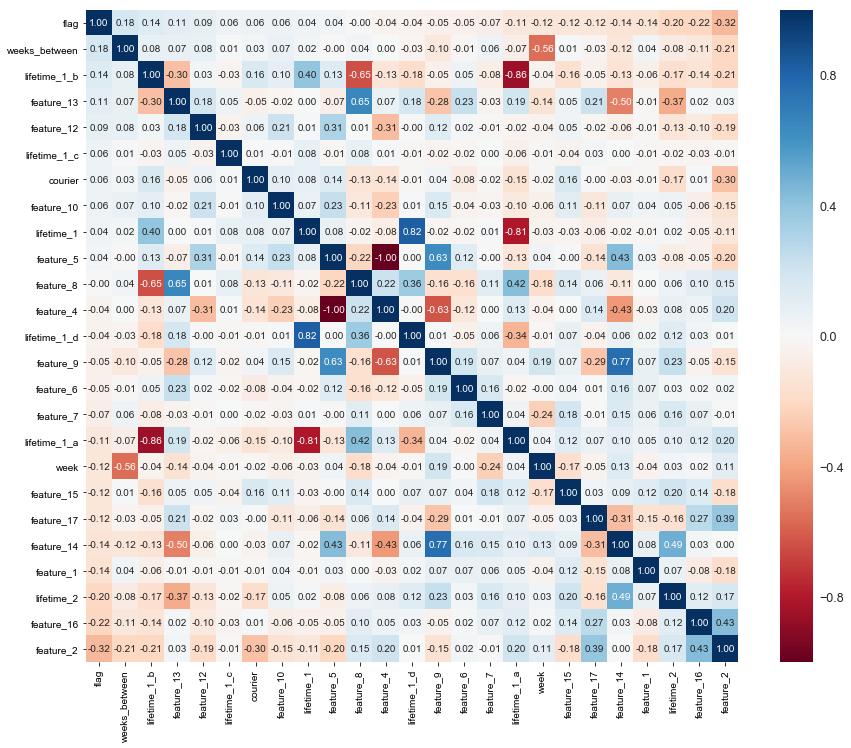

In [8]:
# flag correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
k = 25 #number of variables for heatmap
cols = corrmat.nlargest(k, flag)[flag].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="RdBu", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<h6 class="text-muted">Random Forest (feature importance)</h6>

In [9]:
features = df.columns[
        (~df.columns.str.contains(flag)) &
        (~df.columns.str.contains('courier'))
        ].values

In [10]:
from sklearn.ensemble import RandomForestClassifier

X = df[features].values
y = df[flag].values

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, y)

df_importances = pd.concat([
    pd.Series(features, name='feature'), 
    pd.Series(rnd_clf.feature_importances_, name='importance')]
    , axis=1)

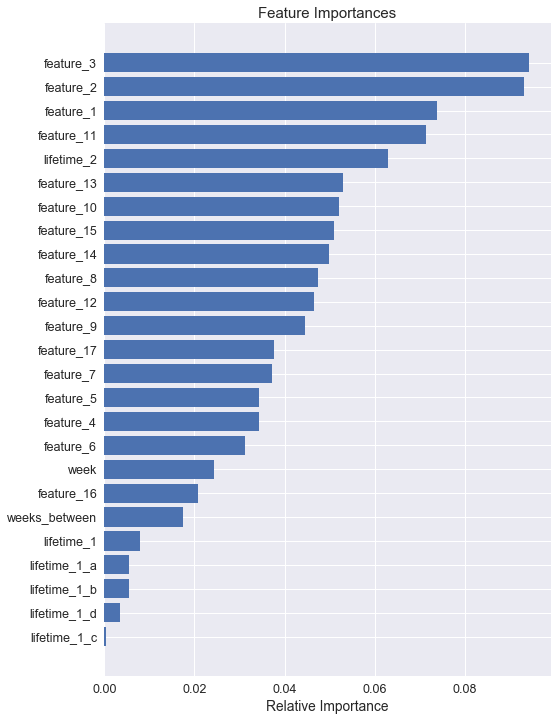

In [11]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

f, ax = plt.subplots(figsize=(8, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

<h6 class="text-muted">Univariate analysis</h6>

Let's now focus on performing an individual analysis for each of the most important features and evaluate how them correlate with our `flag`. To perform a univariate analysis, we will proceed to bin each feature and compare its distribution with the amount of flagged observations.

In small datasets, as explained before, it is good practice to bin continuous features to avoid overfitting. Therefore, the following univariate analysis is greatly useful at considering the binning technique for modelling later on. Through this analysis we also put our efforts into finding the right bins and assigning to each bin a _Weight of Evidence_ that can be of use in the modeling phase (instead of labelling the bins with arbitrary numbers, a weight derived from the log odds is assigned to each bin). This improves significantly the predictive power of simpler linear models.

In [12]:
df_importance = pd.DataFrame([features[indices], importances[indices]]).transpose().rename(columns={0:'feature', 1:'importance'}).sort_values('importance', ascending=False)
df_importance.head(10)

,feature,importance
24,feature_3,0.0943558
23,feature_2,0.0931149
22,feature_1,0.0738598
21,feature_11,0.0714871
20,lifetime_2,0.0628757
19,feature_13,0.0529103
18,feature_10,0.0519841
17,feature_15,0.0510545
16,feature_14,0.0498248
15,feature_8,0.0473404


In [13]:
cols = np.append(features[indices][-8:], [flag])

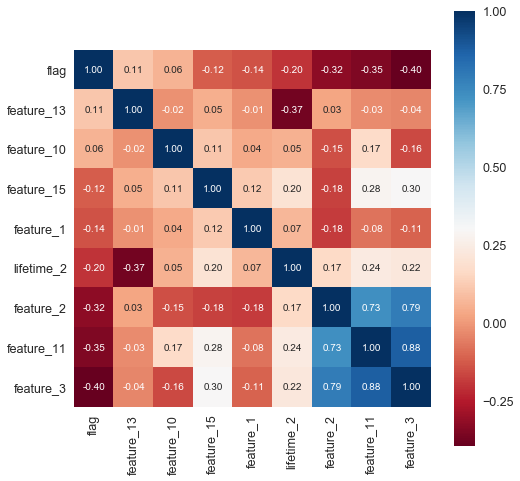

In [14]:
# flag correlation matrix
corrmat = df[cols].corr()
f, ax = plt.subplots(figsize=(8, 8))
k = len(cols) #number of variables for heatmap
cols = corrmat.nlargest(k, flag)[flag].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="RdBu", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<h5 class="text-muted">feature_3</h5>

                  % flag   n1    n
feature_3                         
(1.0, 24.0]     0.665354  338  508
(24.0, 47.0]    0.451306  380  842
(47.0, 70.0]    0.274684  217  790
(70.0, 92.0]    0.188100   98  521
(92.0, 115.0]   0.077220   20  259
(115.0, 138.0]  0.038961    3   77
(138.0, 161.0]  0.000000    0   19
(161.0, 184.0]  0.000000    0    9


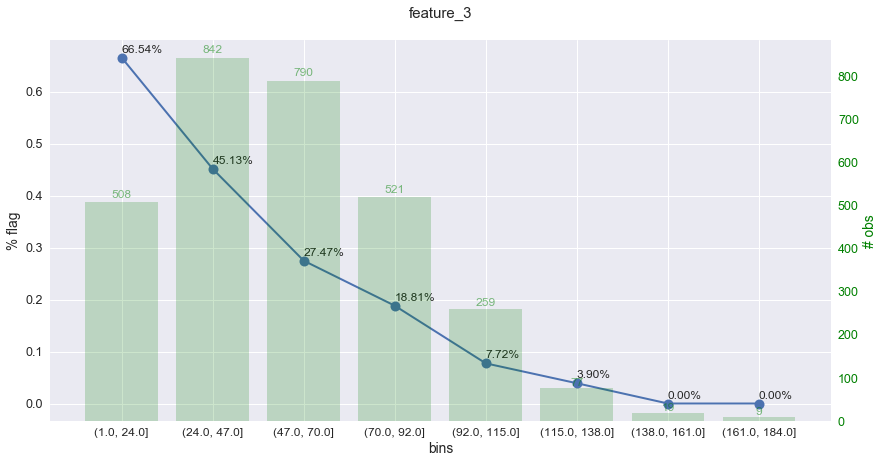

In [15]:
df = univariate_analysis(df, 'feature_3', flag, bins=8, woe=True, precision=0)

The tip provided "*distribution of feature_3 is a hint how the data is generated*" specially makes sense here when comparing this feature with the `flag` for each bin. We can clearly see that the first bucket (<=24) has the largest amount of `flag`. This means that these courier-week combinations correspond to couriers that did not work after the 9th week (`flag` = 1). Therefore, the larger the `feature_3`, the larger the chances those couriers worked in weeks 9 to 11. Conversely, the lower the `feature_3`, the lower the chances those couriers worked in last weeks of the time window.

Now let's examine why there is so much correlation between `feature_3` and `feature_11` and `feature_2`.

<h5 class="text-muted">feature_11</h5>

                % flag   n1    n
feature_11                      
(-0.0, 10.0]  0.611797  446  729
(10.0, 20.0]  0.366492  350  955
(20.0, 31.0]  0.238916  194  812
(31.0, 41.0]  0.126100   43  341
(41.0, 82.0]  0.122340   23  188


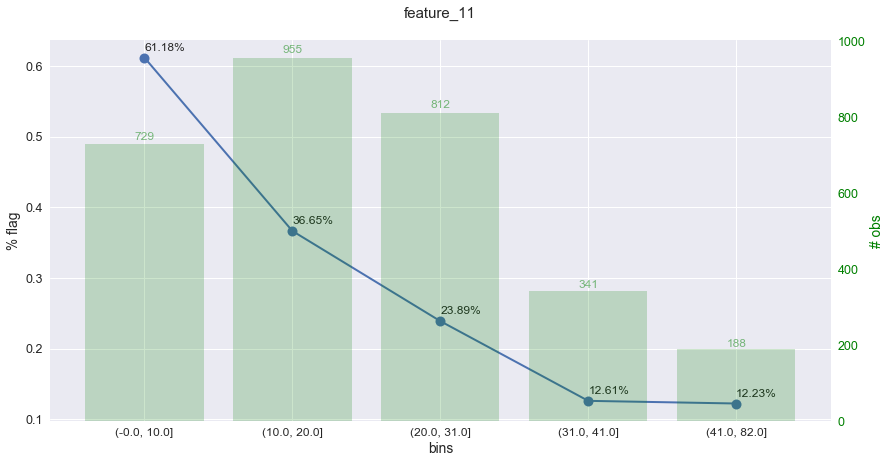

In [16]:
df = univariate_analysis(df, 'feature_11', flag, bins=[-0.1, 10, 20, 31, 41, 82], woe=True, precision=0)

<h5 class="text-muted">feature_2</h5>

                  % flag   n1     n
feature_2                          
(1.0, 29.0]     0.583772  554   949
(29.0, 57.0]    0.280543  372  1326
(57.0, 85.0]    0.174497  104   596
(85.0, 113.0]   0.128205   15   117
(113.0, 141.0]  0.250000    8    32
(141.0, 169.0]  0.600000    3     5


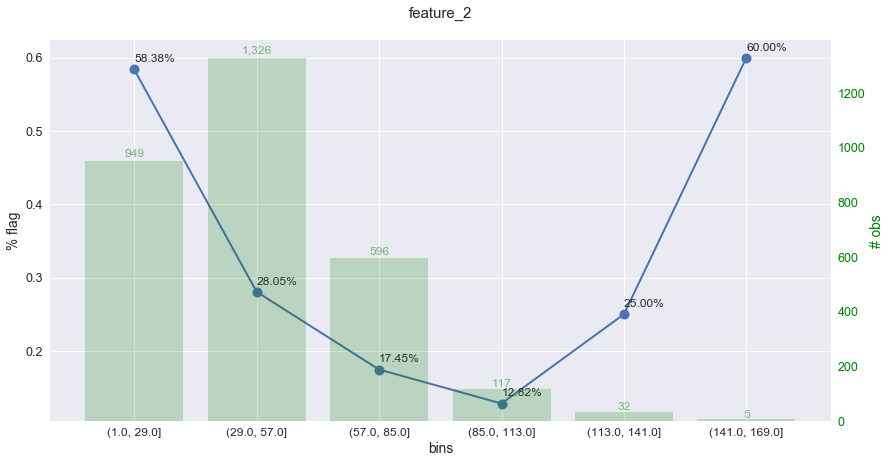

In [17]:
df = univariate_analysis(df, 'feature_2', flag, bins=6, woe=True, precision=0)

It can be clearly seen that correlations among these three features come from the fact that the distribution of each feature follows the same pattern (__the majority of the population is concentrated in the first bins, usually with larger amount of flagged observations__).

<h5 class="text-muted">lifetime_2</h5>

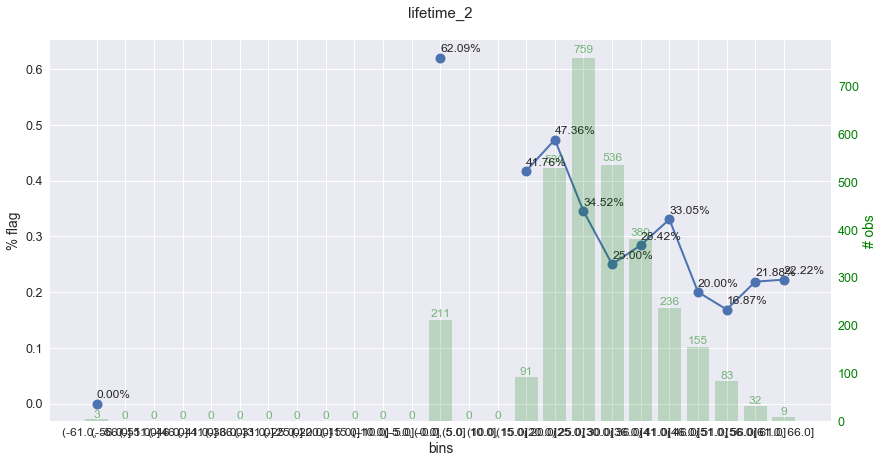

In [18]:
_ = univariate_analysis(df, 'lifetime_2', flag, bins=25, precision=0, detail=False); del _

Although there is high correlation between `feature_3`, `feature_11` and `feature_2`, it is interesting that `lifetime_2` is not as correlated with these features and has a relatively high importance with the `flag`. A more suitable binning fo this variable is shown below.

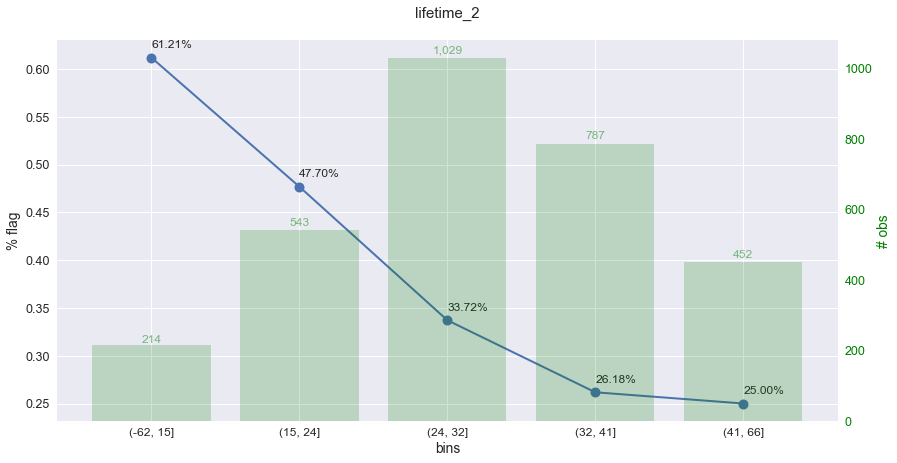

In [19]:
df = univariate_analysis(df, 'lifetime_2', flag, bins=[-62, 15, 24, 32, 41, 66], woe=True, precision=0, detail=False)

<h5 class="text-muted">feature_10</h5>

              % flag   n1     n
feature_10                     
(0, 6]      0.701754   40    57
(6, 8]      0.402857  141   350
(8, 10]     0.283259  379  1338
(10, 12]    0.346154  342   988
(12, 13]    0.465753   68   146
(13, 15]    0.535088   61   114
(15, 17]    0.714286   15    21
(17, 25]    0.909091   10    11


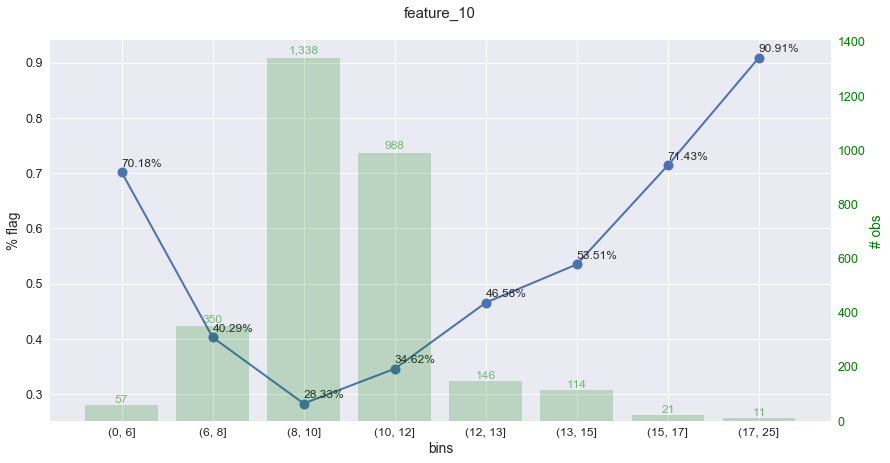

In [20]:
df = univariate_analysis(df, 'feature_10', flag, bins=[0, 6, 8, 10, 12, 13, 15, 17, 25], woe=True, precision=0)

              % flag   n1     n
lifetime_1                     
(0, 1]      0.306079  569  1859
(1, 2]      0.445960  425   953
(2, 3]      1.000000    6     6
(3, 4]      0.270531   56   207


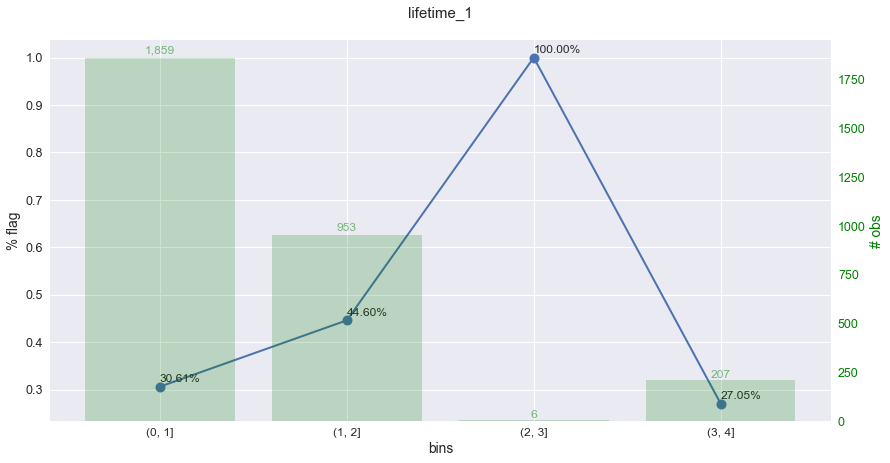

In [21]:
_ = univariate_analysis(df, 'lifetime_1', flag, bins=[0,1,2,3,4], woe=False, precision=0); del _

In [22]:
df[df.columns[df.columns.str.contains('_woe')]].head(2).to_dict()

{'feature_3_woe': {0: -0.42764397601161136, 1: -0.42764397601161136},
 'feature_11_woe': {0: -1.0779096687497451, 1: -0.07574231082553656},
 'feature_2_woe': {0: 0.31873220280222114, 1: 0.31873220280222114},
 'lifetime_2_woe': {0: 0.41383697368941147, 1: 0.41383697368941147},
 'feature_10_woe': {0: -0.22946325278627594, 1: 0.012951152347077981}}

---

## Preprocessing

<h6 class="text-muted">Standardization</h6>

Necessary since there are features with completely different scales.

In [23]:
features = df.columns[
    ~df.columns.str.contains(flag) &
    ~df.columns.str.contains('courier') &
    #~df.columns.str.contains('week') &
    ~df.columns.str.contains('_bin') &
    ~df.columns.str.contains('_woe')
    ].values

In [24]:
from sklearn.preprocessing import StandardScaler

all_predictors = features

scaler = StandardScaler()
df2 = pd.DataFrame(scaler.fit_transform(df[all_predictors]), columns=all_predictors)
df2[flag] = df[flag]
df2['courier'] = df['courier']

<h6 class="text-muted">PCA to extract new features</h6>

* Originally: we tried to cluster together `lifetime_1` features (originally a categorical variable transformed to a one-hot encoding).
* Eventually: we have clustered together the lifetime features with `feature_3`. This yields way better results in modelling. 

In [25]:
pca_features = ['feature_3','lifetime_1','lifetime_2'] #df2.columns[df2.columns.str.contains('lifetime_1')].values

# Separating out the features
X = df2.loc[:, pca_features].values

# Separating out the target
y = df2[[flag]]

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [27]:
finalDf = pd.concat([principalDf, y], axis = 1)

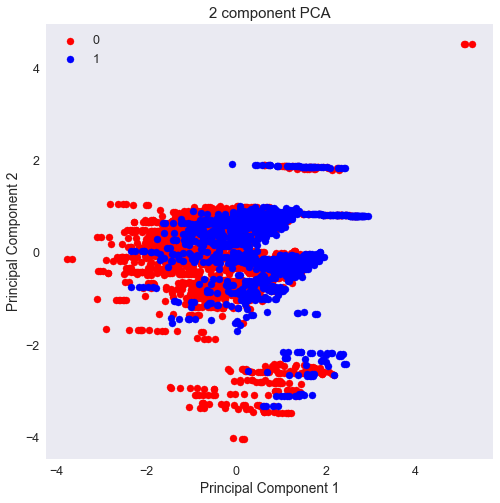

In [28]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 component PCA')
flags = [0,1]
colors = ['r','b']
for flag_, color in zip(flags,colors):
    indicesToKeep = finalDf[flag] == flag_
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(flags)
ax.grid()

In [29]:
df3 = pd.concat([df2, df[df.columns[df.columns.str.contains('_woe')]], finalDf[['PC1', 'PC2']]], axis=1)

<h6 class="text-muted">Train / test split</h6>

In [30]:
# Choose all features except flag
# We will train / test split with more features (than predictors) so in case we want to try different features 
# in modelling, we can access them after splitting

features = df3.columns[
    ~df3.columns.str.contains(flag) &
    ~df3.columns.str.contains('courier') &
    #~df3.columns.str.contains('week') &
    ~df3.columns.str.contains('bin')
    ].values

X = df3[features].values
y = df3[flag].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42) # stratify = y

In [32]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (2722, 32)
X_test: (303, 32)
y_train: (2722,)
y_test: (303,)


In [33]:
df_train = pd.DataFrame(X_train, columns=features)
df_train[flag] = list(y_train)

df_test = pd.DataFrame(X_test, columns=features)
df_test[flag] = y_test

In [34]:
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Train: (2722, 33)
Test: (303, 33)


---

# Modelling 

The decision of which metric is used to fit each algorithm is explained in detail in the `Task3` notebook. However, it is necessary to introduce it because it will appear further below. Since we are interested in classifying couriers, we will be assigning probabilities to each one of them. There is a tradeoff regarding the threshold used to eventually reclassify these probabilities into 1s and 0s (false positive / true positive, ...). Therefore, we will stick to evaluating how well these models are ranking couriers (i.e. using the Area Under the ROC Curve - AUC).

<h2>Model 1 <span class="text-muted">Lasso</span></h2>

We will first try a Lasso regression. Lasso is a regularized linear regression so there are some value for which the predictor will be negative.

In [35]:
df_train_scores = df_train[[flag]]
df_test_scores = df_test[[flag]]

In [36]:
list(df.columns[df.columns.str.contains('_woe')].values)

['feature_3_woe',
 'feature_11_woe',
 'feature_2_woe',
 'lifetime_2_woe',
 'feature_10_woe']

Remove features not necessary for modelling:
* `courier`: not used to model since it is just an id (the model results would be definitely better but would not be realistic for production purposes).
* `feature_5`: we have seen that has complete negative correlation with `feature_4`.
* `lifetime_1`: already included in PCA features.

In [37]:
predictors = df3.columns[
    ~df3.columns.str.contains(flag) &
    ~df3.columns.str.contains('courier') &
    ~df3.columns.str.contains('weeks') &
    ~df3.columns.str.contains('lifetime_1') &
    ~df3.columns.str.contains('_woe') &
    ~df3.columns.str.contains('_bin') &
    ~df3.columns.str.contains('feature_5')
    ].values

In [38]:
list(predictors)

['week',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'lifetime_2',
 'PC1',
 'PC2']

In [39]:
predictors_optimal = [
    'feature_1', 
    'feature_3',
    'feature_8',
    'feature_16',
    'feature_2_woe',
    'feature_10_woe',
    'lifetime_2_woe',
    'PC1',
    'PC2'
]

In [40]:
from sklearn.linear_model import LassoCV

def model_lasso(train, test, predictors):
    
    clf = LassoCV(cv=10, random_state=0) #Lasso(alpha=1, random_state=0)
    clf.fit(train[predictors].values, train[flag].values.ravel())

    print( "\nModel Report (Train)")
    print( "AUC Score: %f" % metrics.roc_auc_score(train[flag].values, clf.predict(train[predictors].values).ravel()))

    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(test[flag].values, clf.predict(test[predictors].values).ravel()))
       
    zipped = zip(list(predictors), clf.coef_)
    zipped = sorted(zipped, key=lambda x: abs(x[1]), reverse=True)

    print("\nList of predictors:")
    [print( ("%+d" % np.sign(predictor[1]))[0], "{:.2f}".format(abs(predictor[1])), predictor[0] ) for predictor in zipped]
    
    return clf

In [41]:
clf_lasso = model_lasso(df_train, df_test, predictors)


Model Report (Train)
AUC Score: 0.789082

Model Report (Test)
AUC Score: 0.792621

List of predictors:
- 0.12 feature_3
- 0.08 feature_1
- 0.04 feature_2
- 0.03 week
+ 0.03 PC1
- 0.02 feature_7
+ 0.02 PC2
+ 0.02 feature_13
- 0.01 feature_14
- 0.01 feature_16
- 0.00 feature_17
+ 0.00 feature_4
+ 0.00 feature_6
+ 0.00 feature_8
+ 0.00 feature_9
+ 0.00 feature_10
+ 0.00 feature_11
+ 0.00 feature_12
+ 0.00 feature_15
+ 0.00 lifetime_2


In [42]:
df_train_scores['pred_lasso'] = clf_lasso.predict(df_train[predictors])
df_test_scores['pred_lasso'] = clf_lasso.predict(df_test[predictors])

In [43]:
model_lasso(df_train, df_test, predictors_optimal) # model with specific predictors only


Model Report (Train)
AUC Score: 0.785973

Model Report (Test)
AUC Score: 0.792136

List of predictors:
- 0.11 feature_3
- 0.10 lifetime_2_woe
- 0.10 feature_2_woe
- 0.09 feature_1
- 0.09 feature_10_woe
+ 0.03 feature_8
- 0.02 feature_16
+ 0.01 PC2
+ 0.00 PC1


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
    verbose=False)

---
<h2>Model 2 <span class="text-muted">Random Forest</span></h2>

In [44]:
def model_rnd(train, test, predictors):

    clf = RandomForestClassifier(n_estimators=3000, n_jobs=-1, random_state=42)
    clf.fit(train[predictors].values, train[flag].values.ravel())

    print( "\nModel Report (Train)")
    print( "AUC Score: %f" % metrics.roc_auc_score(train[flag].values, clf.predict_proba(train[predictors].values)[:,1]))

    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(test[flag].values, clf.predict_proba(test[predictors].values)[:,1]))
       
    zipped = zip(list(predictors), clf.feature_importances_)
    zipped = sorted(zipped, key=lambda x: abs(x[1]), reverse=True)

    print("\nList of predictors:")
    [print( ("%+d" % np.sign(predictor[1]))[0], "{:.2f}".format(abs(predictor[1])), predictor[0] ) for predictor in zipped]
    
    return clf

In [45]:
clf_rnd = model_rnd(df_train, df_test, predictors)


Model Report (Train)
AUC Score: 1.000000

Model Report (Test)
AUC Score: 0.825680

List of predictors:
+ 0.09 PC1
+ 0.08 feature_3
+ 0.08 feature_2
+ 0.07 feature_1
+ 0.06 feature_11
+ 0.06 PC2
+ 0.05 feature_15
+ 0.05 lifetime_2
+ 0.05 feature_13
+ 0.05 feature_10
+ 0.05 feature_8
+ 0.05 feature_14
+ 0.04 feature_12
+ 0.04 feature_9
+ 0.04 feature_4
+ 0.04 feature_17
+ 0.03 feature_7
+ 0.03 feature_6
+ 0.02 week
+ 0.02 feature_16


In [46]:
df_train_scores['pred_rnd'] = clf_rnd.predict_proba(df_train[predictors])[:,1]
df_test_scores['pred_rnd'] = clf_rnd.predict_proba(df_test[predictors])[:,1]

In [47]:
clf_rnd = model_rnd(df_train, df_test, predictors_optimal)


Model Report (Train)
AUC Score: 1.000000

Model Report (Test)
AUC Score: 0.821529

List of predictors:
+ 0.18 PC1
+ 0.18 feature_3
+ 0.16 PC2
+ 0.15 feature_1
+ 0.14 feature_8
+ 0.06 feature_2_woe
+ 0.05 feature_10_woe
+ 0.04 feature_16
+ 0.04 lifetime_2_woe


---
<h2>Model 3 <span class="text-muted">XGBoost</span></h2>

In [48]:
import xgboost as xgb
from xgboost import XGBClassifier

def model_xgboost(alg, 
             dtrain, 
             dtest, 
             predictors, 
             verbose=0, 
             useTrainCV=True, 
             cv_folds=5, 
             early_stopping_rounds=50, 
             flag='flag'):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[flag].values.flatten())
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round=alg.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='auc', 
            early_stopping_rounds=early_stopping_rounds, 
            verbose_eval=verbose)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg.get_params())
    
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[flag].values.flatten(),eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # Print model report:
    print( "\nModel Report (Train)")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain[flag].values, dtrain_predictions))
    print( "AUC Score: %f" % metrics.roc_auc_score(dtrain[flag].values, dtrain_predprob))
    
    # Predict validation set:
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]

    # Print model report:
    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(dtest[flag].values, dtest_predprob))
    
    features_df = pd.DataFrame({'feature': pd.Series(predictors), 'importance': alg.feature_importances_})
    features_df = features_df.sort_values('importance', ascending=False)
    ind = np.arange(len(features_df['feature'].values))    # the x locations for the groups
    
    pyplot.figure(num=None, figsize=[12,4])
    pyplot.bar(range(len(features_df)), features_df['importance'].values)
    pyplot.xticks(ind, features_df['feature'].values, rotation='vertical')
    pyplot.ylabel('Feature Importance Score')
    pyplot.show()

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* __max_depth = 5:__ This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
* __min_child_weight = 1:__ A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
* __gamma = 0:__ A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
* __subsample, colsample_bytree = 0.8:__ This is a commonly used used start value. Typical values range between 0.5-0.9.
* __scale_pos_weight = 1:__

Please note that all the above are just initial estimates and will be tuned later. Lets take a low __learning rate of 0.1__ here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 133, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9658
AUC Score: 0.994757

Model Report (Test)
AUC Score: 0.845097


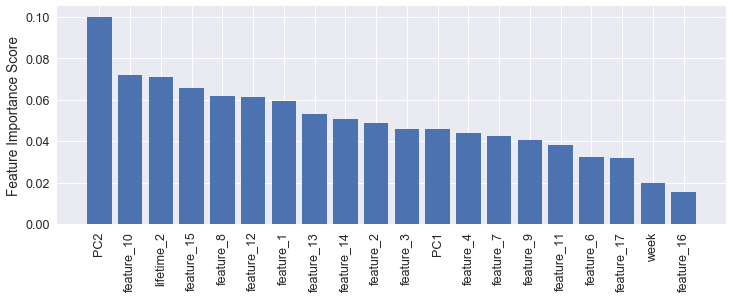

In [49]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_xgboost(xgb1, df_train, df_test, predictors)

## GridSearch

We use GridSearch to find the optimal combination of hyperparameters. A search consists of:
* an estimator (regressor or classifier such as sklearn.svm.SVC());
* a parameter space;
* a method for searching or sampling candidates;
* a cross-validation scheme; and
* a score function.

<h6 class="text-muted">Step 1: Tune max_depth and min_child_weight</h6>

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [50]:
from sklearn.model_selection import GridSearchCV #Perforing grid search

param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=False)

gsearch1.fit(df_train[predictors].values, df_train[flag].values.flatten())

#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.8289158879664533)

There is high risk of overfitting for such large value for `max_depth`. Therefore, we are going to explore a narrower parameter space which should yield better results when generalising to test dataset.

In [51]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[1,2,3]
}

gsearch2 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=300,
        max_depth=5,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5, return_train_score=True)

gsearch2.fit(df_train[predictors].values, df_train[flag].values.flatten())

#gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 2}, 0.8293294510883747)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 135, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.957
AUC Score: 0.992474

Model Report (Test)
AUC Score: 0.845291


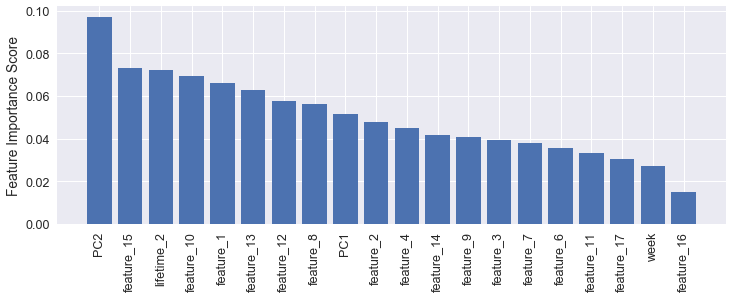

({'max_depth': 5, 'min_child_weight': 2}, 0.8293294510883747)

In [52]:
model_xgboost(gsearch2.best_estimator_, df_train, df_test, predictors)
gsearch2.best_params_, gsearch2.best_score_

The optimal values are `max_depth` = 5 and `min_child_weight` = 2, for now.

<h6 class="text-muted">Step 2: Tune gamma</h6>

Now let's tune gamma value using the parameters already tuned above. 

In [53]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch3.fit(df_train[predictors].values, df_train[flag].values.flatten())

gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.8293294510883747)

This shows that our original value of `gamma` = 0 was optimal. However, since gamma is a regularization parameter and there is a significant difference in terms of score, let's crank it up a little bit. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 155, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9669
AUC Score: 0.995703

Model Report (Test)
AUC Score: 0.856262


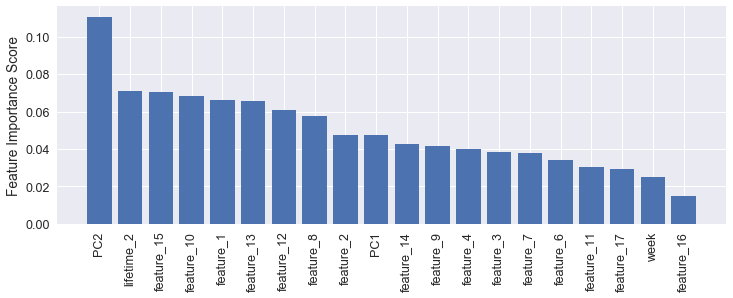

In [54]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_xgboost(xgb2, df_train, df_test, predictors)

The final parameters are:

* `max_depth`: 5
* `min_child_weight`: 2
* `gamma`: 0.1

<h6 class="text-muted">Step 3: Tune subsample and colsample_bytree</h6>

The next step would be try different `subsample` and `colsample_bytree` values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with. 

In [55]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=0),
    param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch4.fit(df_train[predictors].values, df_train[flag].values.flatten())

gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.8339379955193346)

Here, we found 0.8 as the optimum value for `colsample_bytree` and 0.9 for `subsample`. Now we should try values in 0.05 interval around these.

In [56]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,95,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)]
}

gsearch5 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch5.fit(df_train[predictors].values, df_train[flag].values.flatten())

gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.8339379955193346)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 157, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.9}

Model Report (Train)
Accuracy : 0.971
AUC Score: 0.996068

Model Report (Test)
AUC Score: 0.854563


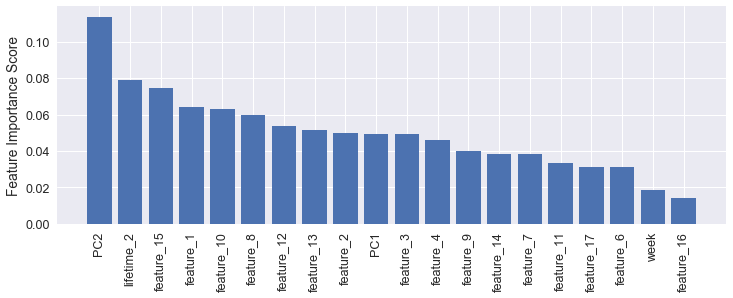

In [57]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_xgboost(xgb3, df_train, df_test, predictors)

We can see that these values now yield better scores for the train but, conversely, worse scores for the test.

* `subsample`: 0.90
* `colsample_bytree`: 0.80

However, 0.80 for both values works better.

<h6 class="text-muted">Step 4: Tuning Regularization Parameters</h6>

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as `gamma` provides a substantial way of controlling complexity. But we should always try it. I’ll tune `reg_alpha` value here and leave it upto you to try different values of `reg_lambda`.

In [58]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch6.fit(df_train[predictors].values, df_train[flag].values.flatten())

gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([1.21163759, 1.27254663, 1.25932226, 1.2079277 , 0.33403964]),
  'std_fit_time': array([0.03102772, 0.01426696, 0.03934002, 0.03212011, 0.02182525]),
  'mean_score_time': array([0.01482992, 0.01387196, 0.01169291, 0.01284757, 0.00161223]),
  'std_score_time': array([1.93943566e-03, 2.01254813e-03, 1.08050049e-03, 1.21319126e-03,
         2.88537313e-05]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.80628272, 0.80879699, 0.8036945 , 0.8054397 , 0.7399651 ]),
  'split1_test_score': array([0.83565534, 0.83743012, 0.84886266, 0.83790339, 0.75944331]),
  'split2_test_score': array([0.8323572 , 0.82911823, 0.83040495, 0.8396338 , 0.75678114]),
  'split3_test_score': array([0.8413

You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 236, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9919
AUC Score: 0.999649

Model Report (Test)
AUC Score: 0.858544


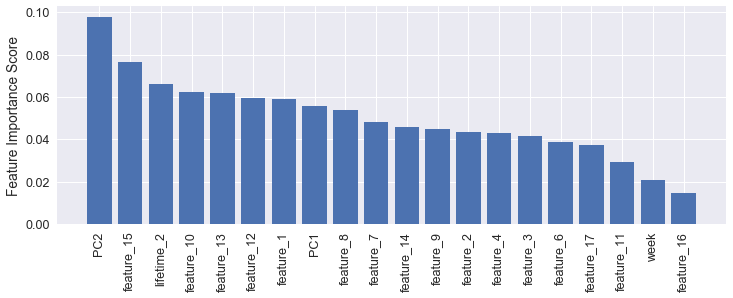

In [59]:
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_xgboost(xgb4, df_train, df_test, predictors)

`reg_alpha` = 1

<h6 class="text-muted">Step 5: Reducing the Learning Rate</h6>

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 1216, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9497
AUC Score: 0.990340

Model Report (Test)
AUC Score: 0.846796


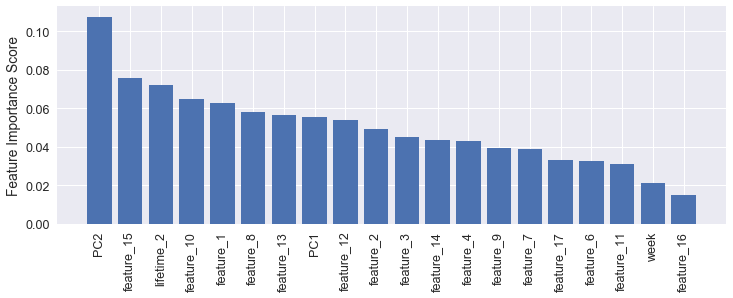

In [60]:
xgb5 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_xgboost(xgb5, df_train, df_test, predictors)

Reducing the `learning_rate` did not work as expected and the score reduced slightly.

In [61]:
df_train_scores['pred_xgb'] = xgb4.predict_proba(df_train[predictors])[:,1]
df_test_scores['pred_xgb'] = xgb4.predict_proba(df_test[predictors])[:,1]

## Final notes

We have seen how different algorithms perform in the previous section. We have focused on optimizing xgboost parameters with grid search since this model outperforms the rest (not significantly). In the figure below we can see how predictions from different models correlate for both the train and test set.

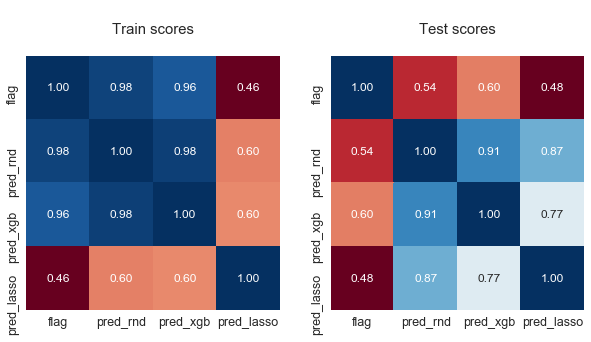

In [62]:
# flag correlation matrix
cols = df_train_scores.columns.values
k = len(cols) # number of variables for heatmap

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

corrmat = df_train_scores[cols].corr()
cols = corrmat.nlargest(k, flag)[flag].index
cm = np.corrcoef(df_train_scores[cols].values.T)
sns.set(font_scale=1.24)
hm = sns.heatmap(cm, 
                 cmap="RdBu", 
                 cbar=False, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 12}, 
                 yticklabels=cols.values, 
                 xticklabels=cols.values,
                 ax=ax1)
ax1.set_title('\nTrain scores\n')

corrmat = df_test_scores[cols].corr()
#cols = corrmat.nlargest(k, flag)[flag].index
cm = np.corrcoef(df_test_scores[cols].values.T)
hm = sns.heatmap(cm, 
                 cmap="RdBu", 
                 cbar=False, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 12}, 
                 yticklabels=cols.values, 
                 xticklabels=cols.values,
                 ax=ax2)
ax2.set_title('\nTest scores\n')
plt.show()

The best model, after fine tuning, is the xgboost. 
* It is important to recall that with a much more simpler model (Lasso) it is also possible to reach relatively high AUC scores in the test set (0,792 with a reduced selection of features and no tuning).
* Dropping some predictors has also been important. After getting rid of `feature_5`, which is -100% correlated with `feature_4`, the scores have improved substantially.
* Another key feature is the PCA, which has produced a really predictive feature (`PC2`).
* Fine tuning of hyper-parameters has led to higher scores.

<h6 class="text-muted">Saving the Model</h6>

In [63]:
import pickle

# save model to file
pickle.dump(xgb4, open("xgb.pickle.dat", "wb"))

In [64]:
# save predictors
f = open('predictors.txt', 'w')

for predictor in list(predictors):
    f.write("%s\n" % predictor)

In [65]:
# modelling dataset
df_train['train'] = 1
df_test['train'] = 0
df_total = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df_total.to_csv('./data/Courier_data_model.csv', sep=',', index=False)